In [1]:
import ase
import matplotlib.pyplot as plt
import numpy as np

import abtem

# Frozen Phonons

In [2]:
#so far - assumed static atomic structure; now including vibrations of Atoms through Frozen Phonon approx. 
#Frozen Phonons simmulate effect of phonons on electron scattering by taking the average of several frozen snapshots
#each snapshot created by applying random ofsets to static structure (displacement is based on gaussian distribution)
#nehmen Inelastizität (also kein Energieverslust) an, Größenordnung der Verluste vernachlässigbar im Vgl zur Primärstrahlenergie.

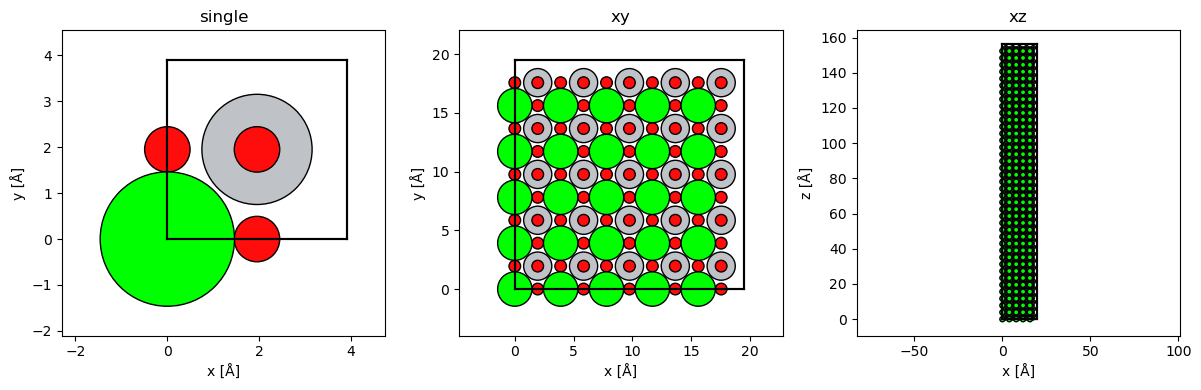

In [2]:
#create SrTiO3 - single cell
a = 3.905 #lattice constant in angstrom, vgl. https://www.sigmaaldrich.com/AT/de/product/aldrich/634689
positions = [(0, 0, 0), (a/2, a/2, a/2), (a/2, a/2, 0),(a/2, 0, a/2), (0, a/2, a/2)]
srtio3 = ase.Atoms('SrTiO3', positions=positions, pbc=True, cell=(a, a, a))

#structure
repetitions = (5, 5, 40)
srtio3_structure = srtio3*repetitions

#plot
fig, (ax1, ax2, ax3)  = plt.subplots(1,3, figsize=(12,4))
abtem.show_atoms(srtio3, ax=ax1, title="single")
abtem.show_atoms(srtio3_structure, ax=ax2, title="xy")
abtem.show_atoms(srtio3_structure, ax=ax3, title="xz", plane='xz')

plt.tight_layout()

In [3]:
#export strontium titanate for later usage
ase.io.write('./data/srtio3.cif', srtio3)

In [3]:
#get lenghts & angles
print(srtio3.cell.cellpar())
print(srtio3_structure.cell.cellpar()) #höhe bei 40 lagen also ca 15 nm

[ 3.905  3.905  3.905 90.    90.    90.   ]
[ 19.525  19.525 156.2    90.     90.     90.   ]


In [4]:
#create frozen phonon configurations, based on 10 frozen images, with standarddev of the gaussian of 0.1 A°
#Anmerkung: thinner samples might need more snapshots
frozen_phonons = abtem.FrozenPhonons(srtio3_structure, num_configs=10, sigmas=0.1, seed=100)

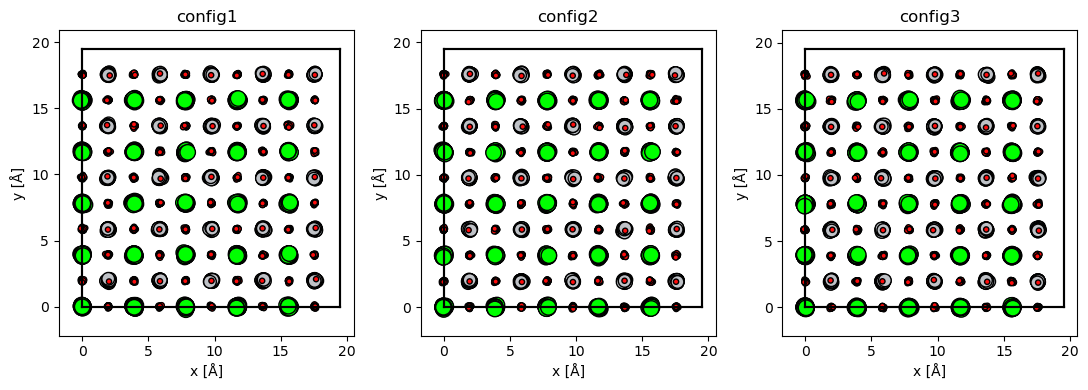

In [6]:
#we want to plot different snapshots
#prep: create iterator object and list of configurations
frozen_it = iter(frozen_phonons)
atoms_configuration_list = [None] * frozen_phonons.shape[0]

for config_i in range(frozen_phonons.shape[0]):
    atoms_configuration_list[config_i] = next(frozen_it)

indizes = (0,4,9)

#plot
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(11, 4))
abtem.show_atoms(atoms_configuration_list[indizes[0]], scale=0.3, ax=ax1, title="config1")
abtem.show_atoms(atoms_configuration_list[indizes[1]], scale=0.3, ax=ax2, title="config2")
abtem.show_atoms(atoms_configuration_list[indizes[2]], scale=0.3, ax=ax3, title="config3")

plt.tight_layout()

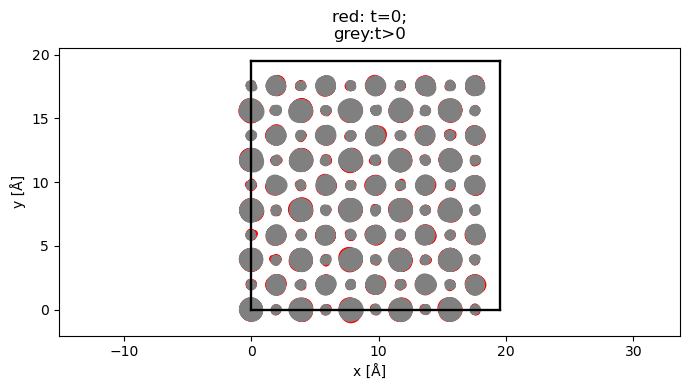

In [7]:
#are they moving?
fig, ax = plt.subplots(1, 1, figsize=(7, 4))

abtem.show_atoms(atoms_configuration_list[indizes[0]], scale=0.4, ax=ax, color="red")
abtem.show_atoms(atoms_configuration_list[indizes[2]], scale=0.4, ax=ax, color="grey", title="red: t=0;\ngrey:t>0",)
plt.tight_layout()

### Potential & Exit Waves

In [5]:
#building Potential by using phononis instead of atoms
potential_static = abtem.Potential(srtio3_structure, gpts=432, slice_thickness=2) #thickness wieder 2A° steps in z-direction -> bei 160 A°-> etwa 80 slices
potential_phonon = abtem.Potential(frozen_phonons, gpts=432, slice_thickness=2)

#potential_atoms.build().shape
potential_phonon.build().shape

(10, 79, 432, 432)

In [7]:
potential_phonon.sampling

(0.045196759259259256, 0.045196759259259256)

In [9]:
#send plane wave of 150 keV
initial_waves = abtem.PlaneWave(energy=150e3)

exit_wave_static = initial_waves.multislice(potential=potential_static).compute()
exit_wave_phonon = initial_waves.multislice(potential=potential_phonon).compute()

[########################################] | 100% Completed | 9.89 ss
[########################################] | 100% Completed | 29.44 s


In [10]:
type(exit_wave_phonon)

abtem.waves.Waves

In [11]:
exit_wave_phonon.shape

(10, 432, 432)

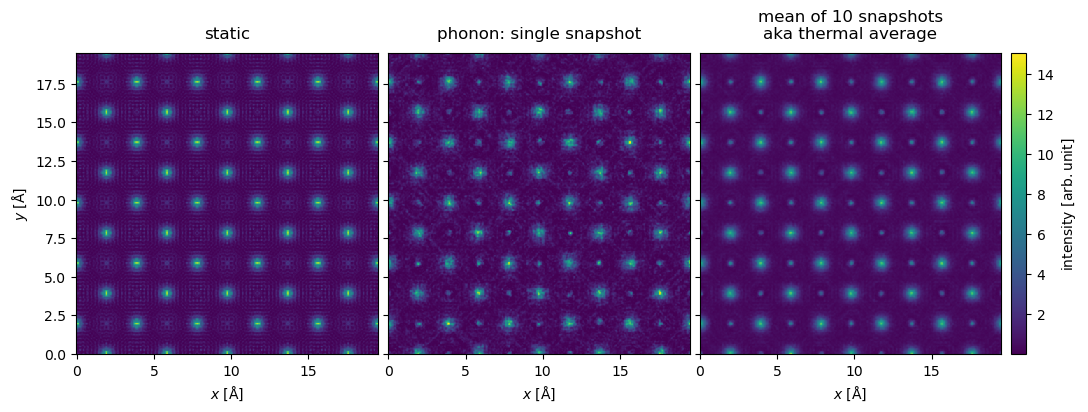

In [12]:
#plot
stack = abtem.stack([exit_wave_static.intensity(),
                     exit_wave_phonon[0].intensity(), 
                     exit_wave_phonon.intensity().mean(0)], ('static', 'phonon: single snapshot', 'mean of 10 snapshots\naka thermal average'))
vis = stack.show(explode=True, cbar=True, common_color_scale=True, figsize=(12,5))
#Null bei .mean(0) steht für axis, über die gemittelt wird.
#anm.: selbes Bild auch ohne .intensity()?

### Diffraction Patterns

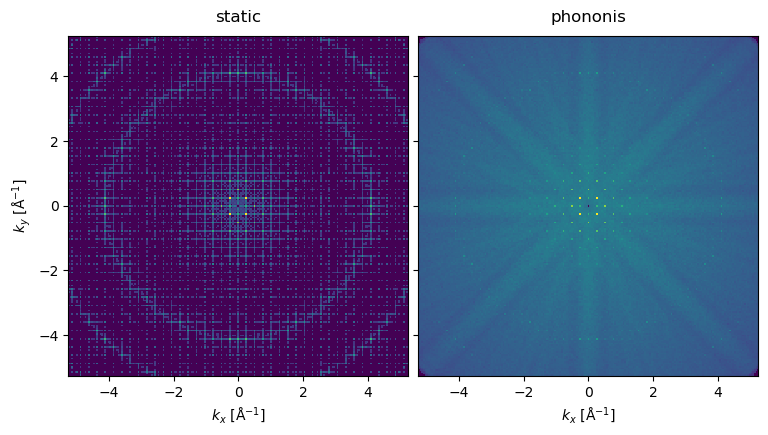

In [13]:
diffpat_static = exit_wave_static.diffraction_patterns(max_angle='valid', block_direct=True)
diffpat_phonon = exit_wave_phonon.diffraction_patterns(max_angle='valid', block_direct=True).mean(0)
#max_angle=valid: Downsample to the largest rectangle that fits inside the circle with a radius defined by the antialias cutoff scattering angle.(?)

diff_patts = abtem.stack([diffpat_static,diffpat_phonon],('static', 'phononis'))
vis = diff_patts.show(explode=True, power=0.1, figsize=(8,4))


Explaination, see: https://abtem.readthedocs.io/en/latest/user_guide/walkthrough/frozen_phonons.html \
"With the frozen phonon ensamble, the higher-order spots are significantly dampened compared to the static model. That intensity is redistributed to a diffuse background with Kikuchi lines that are visible as bands radiating from the center. The Laue diffraction rings (also known as HOLZ lines) visible in the static model are also significantly dampened."

In [14]:
#..vgl:

diff_patts.crop(20).index_diffraction_spots(cell=3.905).to_dataframe()

hkl,0 0 0,0 1 0,0 2 0,0 -2 0,0 -1 0,1 0 0,1 1 0,1 2 0,1 -2 0,1 -1 0,...,2 1 0,2 -1 0,-2 0 0,-2 1 0,-2 -1 0,-1 0 0,-1 1 0,-1 2 0,-1 -2 0,-1 -1 0
,,,,,,,,,,,,,,,,,,,,,
static,0.0,0.000864,0.011191,0.011191,0.000864,0.000864,0.102162,0.000183,0.000183,0.102162,...,0.000183,0.000183,0.011191,0.000183,0.000183,0.000864,0.102162,0.000183,0.000183,0.102162
phononis,0.0,0.001540,0.014749,0.015098,0.001238,0.001422,0.100036,0.000017,0.000042,0.099445,...,0.000027,0.000033,0.014645,0.000028,0.000034,0.001327,0.098564,0.000021,0.000043,0.097790


### STEM Simulations with Phononis

In [15]:
#setup
probe = abtem.Probe(energy=150e3, semiangle_cutoff=20)
scan = abtem.LineScan(start=(0,0), end=(1/repetitions[0], 1/repetitions[1]),
                     fractional=True, potential=potential_static, endpoint=False) #potential wird nur für grid gebraucht
probe.grid.match(potential_static)

In [16]:
#measure
measurement_static = probe.scan(potential_static, scan=scan).compute()
measurement_phonon = probe.scan(potential_phonon, scan=scan).compute()

[########################################] | 100% Completed | 20.91 ss
[########################################] | 100% Completed | 99.71 ss


In [17]:
measurements = abtem.stack([measurement_static, measurement_phonon],("static", "phononis"))

#FlexibleAnnularDetector was used by default - now assign BF, MAADF, HAADF
detectors_stacked = (abtem.stack([
            measurements.integrate_radial(inner=0, outer=20),
            measurements.integrate_radial(inner=50, outer=100),
            measurements.integrate_radial(inner=50, outer=120),
            measurements.integrate_radial(inner=80, outer=200),],
        ("[0, 20] mrad", "[50, 100] mrad", "[50, 120] mrad", "[65, 200] mrad"),    )
    .interpolate(0.1)
    .tile(2))
detectors_stacked.shape

(4, 2, 112)

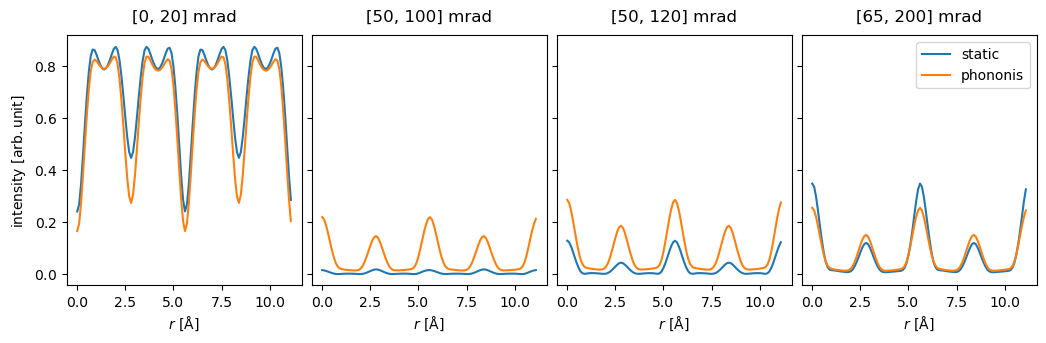

In [40]:
#plot selection of first axis by using explode and overlay (both numbers -> axis)

#vis = detectors_stacked.show(explode=0, overlay=1, figsize=(11,3), common_scale=False)
vis = detectors_stacked.show(explode=0, overlay=1, figsize=(11,3))
handles, labels = plt.gca().get_legend_handles_labels()#gca = get currend axis
plt.legend(handles, labels, loc='upper right')

We can see that phonons amplify the scattering of electrons, except for peaks at very high angles.
The two pictures in the middle show the sensitivity of the scattering to the inclusion of the first Laue ring (~110mrad)

In [41]:
handles